In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
#%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 9)

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 8)
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
import requests
from pathlib import Path
import time 

def fetch_and_cache(data_url, file, data_dir="data", force=False):
    """
    Download and cache a url and return the file object.
    
    data_url: the web address to download
    file: the file in which to save the results.
    data_dir: (default="data") the location to save the data
    force: if true the file is always re-downloaded 
    
    return: The pathlib.Path object representing the file.
    """
    
    ### BEGIN SOLUTION
    data_dir = Path(data_dir)
    data_dir.mkdir(exist_ok = True)
    file_path = data_dir / Path(file)
    # If the file already exists and we want to force a download then
    # delete the file first so that the creation date is correct.
    if force and file_path.exists():
        file_path.unlink()
    if force or not file_path.exists():
        print('Downloading...', end=' ')
        resp = requests.get(data_url)
        with file_path.open('wb') as f:
            f.write(resp.content)
        print('Done!')
        last_modified_time = time.ctime(file_path.stat().st_mtime)
    else:
        last_modified_time = time.ctime(file_path.stat().st_mtime)
        print("Using cached version that was downloaded (UTC):", last_modified_time)
    return file_path
    ### END SOLUTION
    

#https://stackoverflow.com/questions/38511444/python-download-files-from-google-drive-using-url

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
    
def head(filename, lines=5):
    """
    Returns the first few lines of a file.
    
    filename: the name of the file to open
    lines: the number of lines to include
    
    return: A list of the first few lines from the file.
    """
    from itertools import islice
    with open(filename, "r") as f:
        return list(islice(f, lines))
    

**Structure: File Formats**

Reproducible Data Science

In the interest of reproducible data science we will download the data programatically. We have defined some helper functions in the ds100_utils.py file. I can then reuse these helper functions in many different notebooks.

## 1. csv

Restaurant food safety scores for restaurants in San Francisco. The scores and violation information have been made available by the San Francisco Department of Public Health.

In [4]:
restaurants_file = fetch_and_cache(
    "https://data.sfgov.org/api/views/pyih-qa8i/rows.csv", # DL from this website
    "restaurants.csv",         # save as this file
    force=False)       

Using cached version that was downloaded (UTC): Wed Jul  6 15:24:14 2022


Before we even begin to load the data it often helps to understand a little about the high-level structure:

How big is the data file?
How is the data file formatted?
How do we read the data into pandas?
## **1. How big is the data?**

In [5]:
import os
print(restaurants_file, "is", os.path.getsize(restaurants_file) / 1e6, "MB")

data\restaurants.csv is 12.093999 MB


Since these seem to be text files I might also want to investigate the number of lines, which often corresponds to the number of records.

In [6]:
with open(restaurants_file, "r") as f:
    print(restaurants_file, "is", sum(1 for l in f), "lines")

data\restaurants.csv is 53974 lines


## 2. How is the data file formatted?
Let's assume that these are text files (and do not contain binary encoded data) so we can print a "few lines" to get a better understanding of the file.

Notice that below I use the repr function to return the raw string with special characters. This is helpful in deducing the file format.
### Don't blindly trust the data

In [7]:
print(restaurants_file, "=======================")
with open(restaurants_file, "r") as f:
    for i in range(10):
        print(f"{i:03} | {repr(f.readline())}")

data\restaurants.csv =======================
000 | 'business_id,business_name,business_address,business_city,business_state,business_postal_code,business_latitude,business_longitude,business_location,business_phone_number,inspection_id,inspection_date,inspection_score,inspection_type,violation_id,violation_description,risk_category,Neighborhoods,SF Find Neighborhoods,Current Police Districts,Current Supervisor Districts,Analysis Neighborhoods\n'
001 | '835,Kam Po Kitchen,801 Broadway St,San Francisco,CA,94133,37.797223,-122.410513,POINT (-122.410513 37.797223),,835_20180917,09/17/2018 12:00:00 AM,88,Routine - Unscheduled,835_20180917_103139,Improper food storage,Low Risk,107,107,6,3,6\n'
002 | "905,Working Girls' Cafe',0259 Kearny St,San Francisco,CA,94108,37.790477,-122.404033,POINT (-122.404033 37.790477),,905_20190415,04/15/2019 12:00:00 AM,87,Routine - Unscheduled,905_20190415_103114,High risk vermin infestation,High Risk,19,19,6,3,8\n"
003 | "1203,TAWAN'S THAI FOOD,4403 GEARY Blvd

## 3. How do we read the data into pandas?
With CSVs, we can use the handy pd.read_csv function:

In [8]:
restaurants = pd.read_csv(restaurants_file)
restaurants.head()

,business_id,business_name,business_address,business_city,...,SF Find Neighborhoods,Current Police Districts,Current Supervisor Districts,Analysis Neighborhoods
0,835,Kam Po Kitchen,801 Broadway St,San Francisco,...,107.00,6.00,3.00,6.00
1,905,Working Girls' Cafe',0259 Kearny St,San Francisco,...,19.00,6.00,3.00,8.00
2,1203,TAWAN'S THAI FOOD,4403 GEARY Blvd,San Francisco,...,5.00,8.00,4.00,11.00
3,1345,Cordon Bleu,1574 California St,San Francisco,...,105.00,4.00,3.00,21.00
4,1352,LA TORTILLA,495 Castro St B,San Francisco,...,38.00,3.00,5.00,5.00


### For TSV files

In [9]:
# restaurants_tsv = pd.read_csv(filename, delimiter='\t')
# restaurants_tsv.head()

In [10]:
#punctuation in a CSV record
with open(restaurants_file, "r") as f:
    for i, line in enumerate(f.readlines()):
        if "Mo'z Cafe," in line:
            print(f"{i:03} | {repr(line)}")
            break

062 | '81508,"Mo\'z Cafe, Inc.",36 05th St,San Francisco,CA,94103,,,,,81508_20190516,05/16/2019 12:00:00 AM,84,Routine - Unscheduled,81508_20190516_103162,Other low risk violation,Low Risk,,,,,\n'


In [11]:
# read_csv is smart!
restaurants[restaurants['business_name'].str.contains("Mo'z")].head()

,business_id,business_name,business_address,business_city,...,SF Find Neighborhoods,Current Police Districts,Current Supervisor Districts,Analysis Neighborhoods
61,81508,"Mo'z Cafe, Inc.",36 05th St,San Francisco,...,NaN,NaN,NaN,NaN
18913,91619,Mo'z Cafe S.F. Inc,5 Masonic Ave,San Francisco,...,NaN,NaN,NaN,NaN
20034,91619,Mo'z Cafe S.F. Inc,5 Masonic Ave,San Francisco,...,NaN,NaN,NaN,NaN
22508,91619,Mo'z Cafe S.F. Inc,5 Masonic Ave,San Francisco,...,NaN,NaN,NaN,NaN
23468,81508,"Mo'z Cafe, Inc.",36 05th St,San Francisco,...,NaN,NaN,NaN,NaN


## 2) JSON
The City of Berkeley Open Data website has a dataset with COVID-19 Confirmed Cases among Berkeley residents by date.

Let's download this file, saving it as a JSON (note the source URL file type):

In [12]:
covid_file = fetch_and_cache(
    "https://raw.githubusercontent.com/DS-100/sp22/main/lec/lec05/data/confirmed-cases.json",
    "confirmed-cases.json",
    force=False)

Using cached version that was downloaded (UTC): Wed Jul  6 15:44:01 2022


## 1. How big is the data file?

In [13]:
print(covid_file, "is", os.path.getsize(covid_file) / 1e6, "MB")

with open(covid_file, "r") as f:
    print(covid_file, "is", sum(1 for l in f), "lines.")

data\confirmed-cases.json is 0.116367 MB
data\confirmed-cases.json is 1110 lines.


## 2. How is the data file formatted?

In [14]:
# raw text
print(covid_file, "======================")
with open(covid_file, "r") as f:
    for i in range(20):
        print(f"{i:03} | {repr(f.readline())}") # zero pad line numbers

data\confirmed-cases.json ======================
000 | '{\n'
001 | '  "meta" : {\n'
002 | '    "view" : {\n'
003 | '      "id" : "xn6j-b766",\n'
004 | '      "name" : "COVID-19 Confirmed Cases",\n'
005 | '      "assetType" : "dataset",\n'
006 | '      "attribution" : "City of Berkeley",\n'
007 | '      "averageRating" : 0,\n'
008 | '      "category" : "Health",\n'
009 | '      "createdAt" : 1587074071,\n'
010 | '      "description" : "Counts of confirmed COVID-19 cases among Berkeley residents by date.",\n'
011 | '      "displayType" : "table",\n'
012 | '      "downloadCount" : 2804,\n'
013 | '      "hideFromCatalog" : false,\n'
014 | '      "hideFromDataJson" : false,\n'
015 | '      "newBackend" : true,\n'
016 | '      "numberOfComments" : 0,\n'
017 | '      "oid" : 37306599,\n'
018 | '      "provenance" : "official",\n'
019 | '      "publicationAppendEnabled" : false,\n'


## Digging into JSON

In [16]:
import json

with open(covid_file, "rb") as f:
    covid_json = json.load(f)

In [17]:
type(covid_json)

dict

## Examine what keys are in the top level json object#

In [18]:
covid_json.keys()

dict_keys(['meta', 'data'])

Observation: The JSON dictionary contains a meta key which likely refers to meta data (data about the data). Meta data often maintained with the data and can be a good source of additional information.



In [19]:
covid_json['meta'].keys()

dict_keys(['view'])

In [20]:
covid_json['meta']['view'].keys()

dict_keys(['id', 'name', 'assetType', 'attribution', 'averageRating', 'category', 'createdAt', 'description', 'displayType', 'downloadCount', 'hideFromCatalog', 'hideFromDataJson', 'newBackend', 'numberOfComments', 'oid', 'provenance', 'publicationAppendEnabled', 'publicationDate', 'publicationGroup', 'publicationStage', 'rowsUpdatedAt', 'rowsUpdatedBy', 'tableId', 'totalTimesRated', 'viewCount', 'viewLastModified', 'viewType', 'approvals', 'columns', 'grants', 'metadata', 'owner', 'query', 'rights', 'tableAuthor', 'tags', 'flags'])

In [21]:
print(covid_json['meta']['view']['description'])

Counts of confirmed COVID-19 cases among Berkeley residents by date.


## Columns Metadata
Another potentially useful key in the metadata dictionary is the columns. This returns a list:

In [24]:
type(covid_json['meta']['view']['columns'])

list

We can browse summary data in the list using python:

## Observations

The above meta data tells us a lot about the columns in the data including column names, potential data anomalies, and a basic statistic.
JSON makes it easier (than CSV) to create **self-documented data**.
Self documenting data can be helpful since it maintains its own description and these descriptions are more likely to be updated as data changes.
Examining the Data Field for Records
We can look at a few entries in the data field. This is what we'll load into Pandas.

In [26]:
for i in range(3):
    print(f"{i:03} | {covid_json['data'][i]}")

000 | ['row-kzbg.v7my-c3y2', '00000000-0000-0000-0405-CB14DE51DAA7', 0, 1643733903, None, 1643733903, None, '{ }', '2020-02-28T00:00:00', '1', '1']
001 | ['row-jkyx_9u4r-h2yw', '00000000-0000-0000-F806-86D0DBE0E17F', 0, 1643733903, None, 1643733903, None, '{ }', '2020-02-29T00:00:00', '0', '1']
002 | ['row-qifg_4aug-y3ym', '00000000-0000-0000-2DCE-4D1872F9B216', 0, 1643733903, None, 1643733903, None, '{ }', '2020-03-01T00:00:00', '0', '1']


 How do we read the file into Pandas? Building a DataFrame from JSON
Let's understand more about the particular structure of this JSON file so that we can decide what (if anything)

In the following block of code we:

Translate the JSON records into a dataframe:

fields: covid_json['meta']['view']['columns']
records: covid_json['data']
Remove columns that have no metadata description. This would be a bad idea in general but here we remove these columns since the above analysis suggests that they are unlikely to contain useful information.

Examine the table.

In [28]:
# Load the data from JSON and assign column titles
covid = pd.DataFrame(
    covid_json['data'],
    columns=[c['name'] for c in covid_json['meta']['view']['columns']])

covid.tail()

,sid,id,position,created_at,...,meta,Date,New Cases,Cumulative Cases
699,row-49b6_x8zv.gyum,00000000-0000-0000-A18C-9174A6D05774,0,1643733903,...,{ },2022-01-27T00:00:00,106,10694
700,row-gs55-p5em.y4v9,00000000-0000-0000-F41D-5724AEABB4D6,0,1643733903,...,{ },2022-01-28T00:00:00,223,10917
701,row-3pyj.tf95-qu67,00000000-0000-0000-BEE3-B0188D2518BD,0,1643733903,...,{ },2022-01-29T00:00:00,139,11056
702,row-cgnd.8syv.jvjn,00000000-0000-0000-C318-63CF75F7F740,0,1643733903,...,{ },2022-01-30T00:00:00,33,11089
703,row-qywv_24x6-237y,00000000-0000-0000-FE92-9789FED3AA20,0,1643733903,...,{ },2022-01-31T00:00:00,42,11131


## Your turn: Mauna Loa CO2 data
CO2 concentrations have been monitored at Mauna Loa Observatory since 1958 (website link).

In [33]:
co2_file = "co2_mm_mlo.txt"

In [34]:
print(co2_file, "is", os.path.getsize(co2_file) / 1e6, "MB")

with open(co2_file, "r") as f:
    print(co2_file, "is", sum(1 for l in f), "lines.")

co2_mm_mlo.txt is 0.051939 MB
co2_mm_mlo.txt is 810 lines.


## How do we read the file into Pandas?
While we could use Python again to check out the contents, let's instead check out this file with JupyterLab (note it's a .txt file. Do we trust this file extension?).

Looking at the first few lines of the data, we spot some relevant characteristics:

The values are separated by white space, possibly tabs.
The data line up down the rows. For example, the month appears in 7th to 8th position of each line.
The 71st and 72nd lines in the file contain column headings split over two lines.

We can use read_csv to read the data into a Pandas data frame, and we provide several arguments to specify that the separators are white space, there is no header (we will set our own column names), and to skip the first 72 rows of the file.

In [40]:
co2 = pd.read_csv(
    co2_file,
    header = None,
    skiprows = 72, #First 71 lines just are a paragraph that describe the data
    sep = '\s+', # regex for continuous whitespace (next lecture)
)
co2.head()

,0,1,2,3,4,5,6
0,1958,3,1958.21,315.71,315.71,314.62,-1
1,1958,4,1958.29,317.45,317.45,315.29,-1
2,1958,5,1958.38,317.50,317.50,314.71,-1
3,1958,6,1958.46,-99.99,317.10,314.85,-1
4,1958,7,1958.54,315.86,315.86,314.98,-1


Exploring Variable Feature Types
Let's go back to the raw data file to understand each feature.

The NOAA webpage might have some useful tidbits (in this case it doesn't).



We'll rerun pd.read_csv, but this time with some custom column names.

In [43]:
co2 = pd.read_csv(
    co2_file, header = None, skiprows = 72, 
    sep = '\s+', # regex for continuous whitespace (next lecture)
    names = ['Yr', 'Mo', 'DecDate', 'Avg', 'Int', 'Trend', 'Days']
)
co2.head()

,Yr,Mo,DecDate,Avg,Int,Trend,Days
0,1958,3,1958.21,315.71,315.71,314.62,-1
1,1958,4,1958.29,317.45,317.45,315.29,-1
2,1958,5,1958.38,317.50,317.50,314.71,-1
3,1958,6,1958.46,-99.99,317.10,314.85,-1
4,1958,7,1958.54,315.86,315.86,314.98,-1


<AxesSubplot:xlabel='DecDate', ylabel='Avg'>

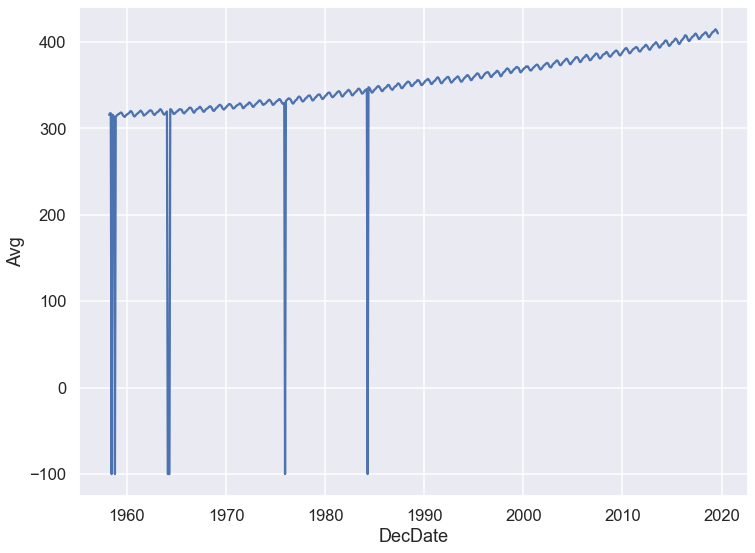

In [45]:
sns.lineplot(x='DecDate', y = 'Avg', data=co2)

Yikes! Plotting the data uncovered a problem. It looks like we have some missing values. What happened here?

In [47]:
co2.head()

,Yr,Mo,DecDate,Avg,Int,Trend,Days
0,1958,3,1958.21,315.71,315.71,314.62,-1
1,1958,4,1958.29,317.45,317.45,315.29,-1
2,1958,5,1958.38,317.50,317.50,314.71,-1
3,1958,6,1958.46,-99.99,317.10,314.85,-1
4,1958,7,1958.54,315.86,315.86,314.98,-1


In [48]:
co2.tail()

,Yr,Mo,DecDate,Avg,Int,Trend,Days
733,2019,4,2019.29,413.32,413.32,410.49,26
734,2019,5,2019.38,414.66,414.66,411.20,28
735,2019,6,2019.46,413.92,413.92,411.58,27
736,2019,7,2019.54,411.77,411.77,411.43,23
737,2019,8,2019.62,409.95,409.95,411.84,29


Some data have unusual values like -1 and -99.99.

Let's check the description at the top of the file again.

-1 signifies a missing value for the number of days Days the equipment was in operation that month.
-99.99 denotes a missing monthly average Avg

How can we fix this? First, let's explore other aspects of our data. Understanding our data will help us decide what to do with the missing values.

## Quality Checks: Reasoning about the data
First, we consider the shape of the data. How many rows should we have?

If chronological order, we should have one record per month.
Data from March 1958 to August 2019.
We should have  records. 12 * (2019-1957) - 2 - 4 = 738 records

In [49]:
co2.shape

(738, 7)

## Understanding Missing Value 1: Days
Days is a time field, so let's analyze other time fields to see if there is an explanation for missing values of days of operation.

Let's start with months Mo.

Are we missing any records? The number of months should have 62 or 61 instances (March 1957-August 2019).

In [51]:
co2["Mo"].value_counts().sort_index()

1     61
2     61
3     62
      ..
10    61
11    61
12    61
Name: Mo, Length: 12, dtype: int64

As expected Jan, Feb, Sep, Oct, Nov, and Dec have 61 occurrences and the rest 62.

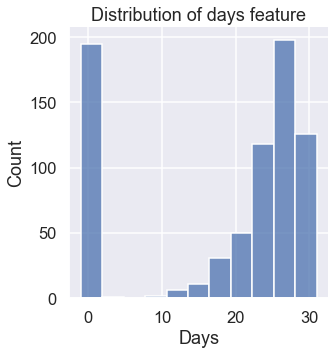

In [53]:
sns.displot(co2['Days']);
plt.title("Distribution of days feature")
plt.show()

In terms of data quality, a handful of months have averages based on measurements taken on fewer than half the days. In addition, there are nearly 200 missing values--that's about 27% of the data!




Finally, let's check the last time feature, year Yr.

Let's check to see if there is any connection between missingness and the year of the recording.

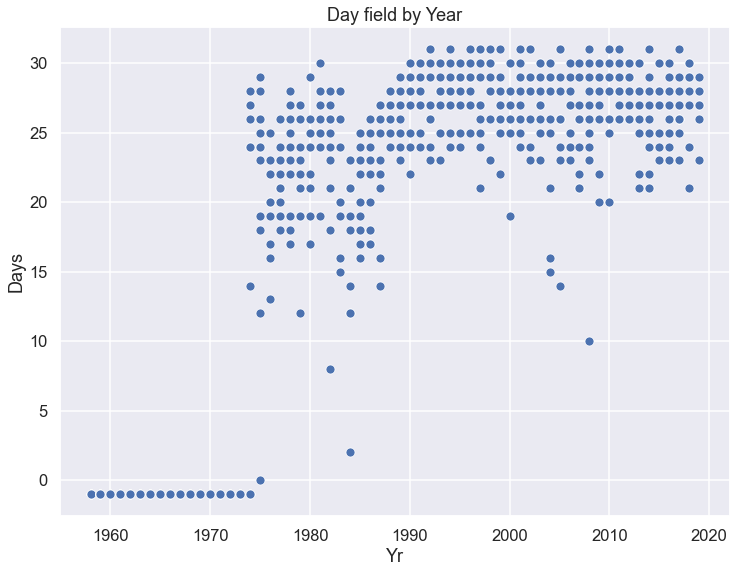

In [54]:
sns.scatterplot(x="Yr", y="Days", data=co2);
plt.title("Day field by Year"); # the ; suppresses output

**Observations:**

All of the missing data are in the early years of operation.
It appears there may have been problems with equipment in the mid to late 80s.

**Potential Next Steps:**

Confirm these explanations through documentation about the historical readings.
Maybe drop earliest recordings? However, we would want to delay such action until after we have examined the time trends and assess whether there are any potential problems.

## Understanding Missing Value 2: Avg
Next, let's return to the -99.99 values in Avg to analyze the overall quality of the CO2 measurements.

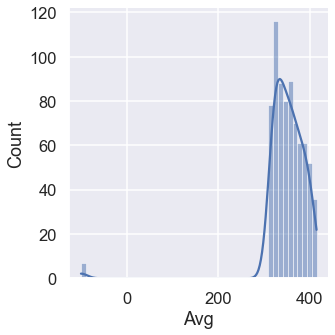

In [58]:
# Histograms of average CO2 measurements
sns.displot(co2['Avg'], kde=True);

In [57]:
co2[co2["Avg"] < 0]

,Yr,Mo,DecDate,Avg,Int,Trend,Days
3,1958,6,1958.46,-99.99,317.10,314.85,-1
7,1958,10,1958.79,-99.99,312.66,315.61,-1
71,1964,2,1964.12,-99.99,320.07,319.61,-1
72,1964,3,1964.21,-99.99,320.73,319.55,-1
73,1964,4,1964.29,-99.99,321.77,319.48,-1
213,1975,12,1975.96,-99.99,330.59,331.60,0
313,1984,4,1984.29,-99.99,346.84,344.27,2


## Drop or Impute Missing Avg Data?

Remember we want to fix the following plot:

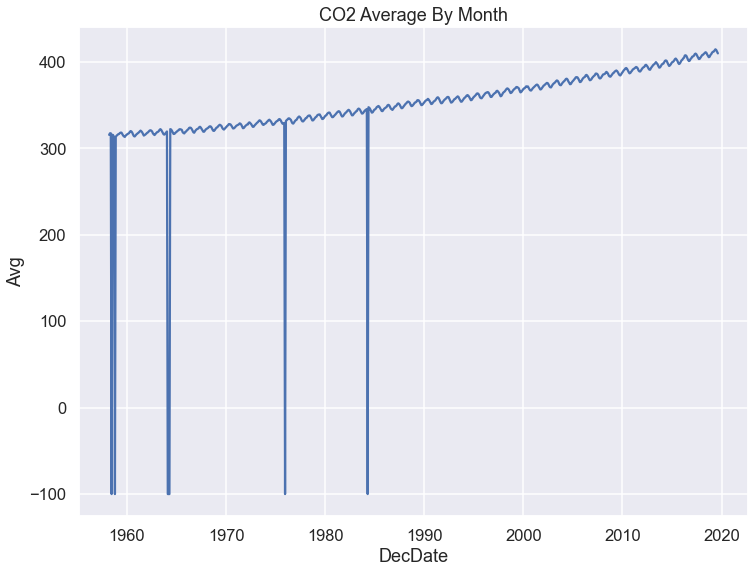

In [60]:
sns.lineplot(x='DecDate', y='Avg', data=co2)
plt.title("CO2 Average By Month");

Since we are plotting Avg vs DecDate, we should just focus on dealing with missing values for Avg.

Let's consider a few options:

1. Drop those records
2. Replace -99.99 with NaN
3. Substitute it with a likely value for the average CO2?

What do you think are the pros and cons of each possible action?

In [61]:
# 1. Drop missing values
co2_drop = co2[co2['Avg'] > 0]

# 2. Replace NaN with -99.99
co2_NA = co2.replace(-99.99, np.NaN)

We'll also use a third version of the data. First, we note that the dataset already comes with a substitute value for the -99.99.

From the file description:

    The interpolated column includes average values from the preceding column (average) and interpolated values where data are missing. Interpolated values are computed in two steps...

The Int feature has values that exactly match those in Avg, except when Avg is -99.99, and then a reasonable estimate is used instead. So, the third version of our data will use the Int feature instead of Avg.

In [62]:
# 3. Use interpolated column which estimates missing Avg values
co2_impute = co2.copy()
co2_impute['Avg'] = co2['Int']

**What's a reasonable estimate?**

To answer this question, let's zoom in on a short time period, say the measurements in 1958 (where we know we have two missing values).

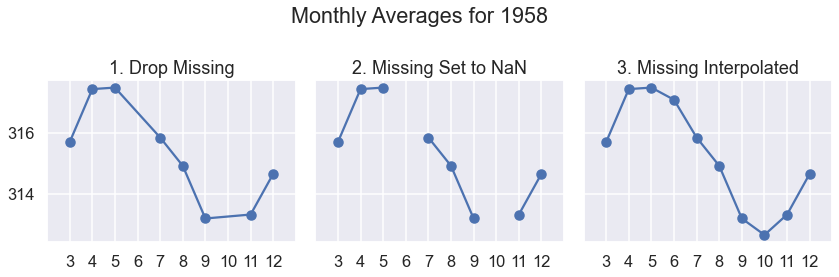

In [64]:
# results of plotting data in 1958

def line_and_points(data, ax, title):
    # assumes single year, hence Mo
    ax.plot('Mo', 'Avg', data=data)
    ax.scatter('Mo', 'Avg', data=data)
    ax.set_xlim(2, 13)
    ax.set_title(title)
    ax.set_xticks(np.arange(3, 13))

def data_year(data, year):
    return data[data["Yr"] == 1958]
    
# uses matplotlib subplots
# you may see more next week; focus on output for now
fig, axes = plt.subplots(ncols = 3, figsize=(12, 4), sharey=True)

year = 1958
line_and_points(data_year(co2_drop, year), axes[0], title="1. Drop Missing")
line_and_points(data_year(co2_NA, year), axes[1], title="2. Missing Set to NaN")
line_and_points(data_year(co2_impute, year), axes[2], title="3. Missing Interpolated")

fig.suptitle(f"Monthly Averages for {year}")
plt.tight_layout()

In the big picture since there are only 7 Avg values missing (<1% of 738 months), any of these approaches would work.

However there is some appeal to **option 3: Imputing:**

1. Shows seasonal trends for CO2
2. We are plotting all months in our data as a line plot

Let's replot our original figure with option 3:

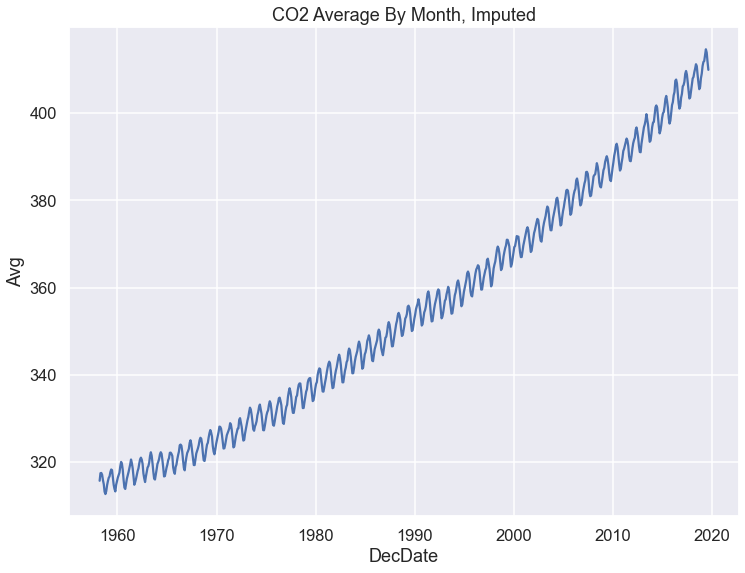

In [66]:
sns.lineplot(x='DecDate', y='Avg', data=co2_impute)
plt.title("CO2 Average By Month, Imputed");